In [258]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import math
import bisect


### Default image path

In [259]:
image_path = "images/test_images/image3.png"

### Display image help function

In [260]:
def display_image(title, image):
    plt.figure(figsize=(8, 8))
    plt.title(title)
    plt.axis('off')
    if len(image.shape) == 2 or image.shape[2] == 1:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

## Basic reading image and display

In [261]:
def remove_background_canny_edge_detection(image_path, debug=True):
    """
    Background removal function using Canny edge detection.
    Returns contours, original image, and binary mask in the same format as the original code.

    Args:
        image_path: Single image path (string)
        debug: Show intermediate steps

    Returns:
        contours: List of contours for puzzle pieces
        original_image: Original loaded image
        binary_mask: Final binary mask
    """

    # Load single image instead of multiple images
    original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if original_image is None:
        raise ValueError(f"Could not load image from {image_path}")

    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    if debug:
        print("🔧 CANNY EDGE JIGSAW PUZZLE DETECTION")
        print("=" * 60)
        display_image("Original Image", original_image)
        display_image("Grayscale Image", gray_image)

    # STEP 1: Preprocessing - Gaussian blur for noise reduction
    if debug:
        print("🔧 STEP 1: Preprocessing - Gaussian blur for noise reduction")

    blur_kernel_size = 5  # Must be odd number
    blurred = cv2.GaussianBlur(gray_image, (blur_kernel_size, blur_kernel_size), 0)

    if debug:
        display_image("After Gaussian Blur", blurred)
        print(f"✅ Applied {blur_kernel_size}x{blur_kernel_size} Gaussian blur")

    # STEP 2: Canny edge detection
    if debug:
        print("🎯 STEP 2: Canny edge detection")

    low_threshold = 50  # Lower threshold for edge linking
    high_threshold = 150  # Upper threshold for strong edges

    canny_edges = cv2.Canny(blurred, low_threshold, high_threshold)

    if debug:
        display_image("Canny Edges", canny_edges)
        edge_pixels = np.count_nonzero(canny_edges)
        total_pixels = canny_edges.shape[0] * canny_edges.shape[1]
        edge_percentage = (edge_pixels / total_pixels) * 100
        print(f"📊 Canny edge statistics:")
        print(f"   Low threshold: {low_threshold}")
        print(f"   High threshold: {high_threshold}")
        print(f"   Edge pixels: {edge_pixels:,} ({edge_percentage:.2f}%)")

    # STEP 3: Dilation - thicken edges
    if debug:
        print("📈 STEP 3: Dilation - thicken edges")

    dilation_kernel_size = 3
    dilation_iterations = 2
    dilation_kernel = np.ones((dilation_kernel_size, dilation_kernel_size), np.uint8)

    dilated_edges = cv2.dilate(canny_edges, dilation_kernel, iterations=dilation_iterations)

    if debug:
        display_image("After Dilation (Thickened Edges)", dilated_edges)
        print(f"📊 Dilation parameters:")
        print(f"   Kernel size: {dilation_kernel_size}x{dilation_kernel_size}")
        print(f"   Iterations: {dilation_iterations}")

    # STEP 4: Morphological closing - fill gaps between edges
    if debug:
        print("🔗 STEP 4: Morphological closing - fill gaps between edges")

    closing_kernel_size = 3
    closing_iterations = 3
    closing_kernel = np.ones((closing_kernel_size, closing_kernel_size), np.uint8)

    closed_edges = cv2.morphologyEx(dilated_edges, cv2.MORPH_CLOSE, closing_kernel, iterations=closing_iterations)

    if debug:
        display_image("After Morphological Closing", closed_edges)
        print(f"📊 Closing parameters:")
        print(f"   Kernel size: {closing_kernel_size}x{closing_kernel_size}")
        print(f"   Iterations: {closing_iterations}")

    # STEP 5: Contour detection and filling
    if debug:
        print("🎨 STEP 5: Contour detection and filling")

    contours_temp, _ = cv2.findContours(closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if debug:
        print(f"Found {len(contours_temp)} contours")

    filled_mask = np.zeros_like(gray_image)
    cv2.drawContours(filled_mask, contours_temp, -1, 255, thickness=cv2.FILLED)

    if debug:
        display_image("Filled Contours", filled_mask)

    # STEP 6: MODERATE morphological operations for cleanup
    if debug:
        print("🧹 STEP 6: MODERATE morphological operations for cleanup")

    cleanup_kernel_size = 6  # Reduced from 12 to 6
    cleanup_kernel = np.ones((cleanup_kernel_size, cleanup_kernel_size), np.uint8)

    morph_closed = cv2.morphologyEx(filled_mask, cv2.MORPH_CLOSE, cleanup_kernel, iterations=1)
    morph_cleaned = cv2.morphologyEx(morph_closed, cv2.MORPH_OPEN, cleanup_kernel, iterations=1)

    if debug:
        display_image("After MODERATE Morphological Close", morph_closed)
        display_image("After MODERATE Morphological Open", morph_cleaned)
        print(f"📊 MODERATE cleanup parameters:")
        print(f"   Cleanup kernel size: {cleanup_kernel_size}x{cleanup_kernel_size}")
        print(f"   Iterations: 1 each")

    # STEP 7: Erosion - reduce object size
    if debug:
        print("📉 STEP 7: Erosion - reduce object size")

    erosion_kernel_size = 3
    chosen_erosion = 2
    erosion_kernel = np.ones((erosion_kernel_size, erosion_kernel_size), np.uint8)
    eroded_mask = cv2.erode(morph_cleaned, erosion_kernel, iterations=chosen_erosion)

    if debug:
        display_image("After Erosion", eroded_mask)

    # STEP 8: Dilation - restore original size
    if debug:
        print("📈 STEP 8: Dilation - restore original size")

    restoration_kernel = np.ones((erosion_kernel_size, erosion_kernel_size), np.uint8)
    restored_mask = cv2.dilate(eroded_mask, restoration_kernel, iterations=chosen_erosion)

    if debug:
        display_image("After Size Restoration (Erosion + Dilation)", restored_mask)

    # STEP 8.5: Final shrinking - reduce dilation slightly
    if debug:
        print("🔧 STEP 8.5: Final shrinking - reduce dilation slightly")

    shrink_kernel = np.ones((10, 10), np.uint8)  # Small kernel for slight shrinking
    final_mask = cv2.erode(restored_mask, shrink_kernel, iterations=1)

    if debug:
        display_image("After Final Shrinking", final_mask)

    # STEP 9: Final contour extraction
    if debug:
        print("🎯 STEP 9: Final results and analysis")

    final_contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Filter by area (remove tiny fragments) - same as original code
    min_area = 200
    final_contours = [cnt for cnt in final_contours if cv2.contourArea(cnt) > min_area]

    # Sort contours by area (same as original code)
    final_contours = sorted(final_contours, key=lambda x: cv2.contourArea(x), reverse=True)

    # Additional filtering similar to original code
    if len(final_contours) > 1:
        reference_area = cv2.contourArea(final_contours[1]) if len(final_contours) > 1 else cv2.contourArea(final_contours[0])
        final_contours = [cnt for cnt in final_contours if cv2.contourArea(cnt) > reference_area / 3]

    if debug:
        print(f"📊 Final Results:")
        print(f"   Objects detected: {len(final_contours)}")
        print(f"After filtering: {len(final_contours)} puzzle pieces")

    return final_contours, original_image, final_mask

## Grayscale conversion

Reading image from path: images/test_images/image3.png
🔧 CANNY EDGE JIGSAW PUZZLE DETECTION


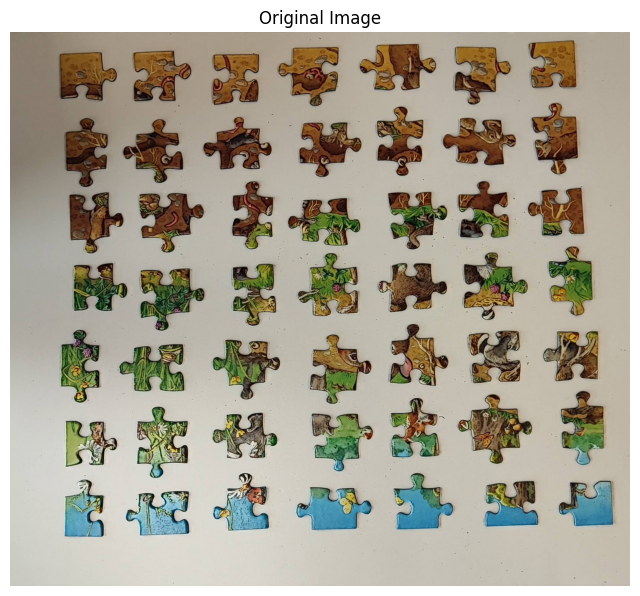

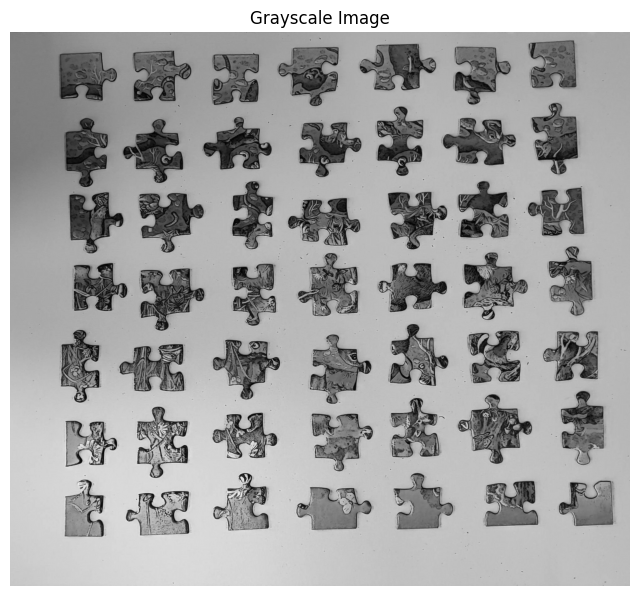

🔧 STEP 1: Preprocessing - Gaussian blur for noise reduction


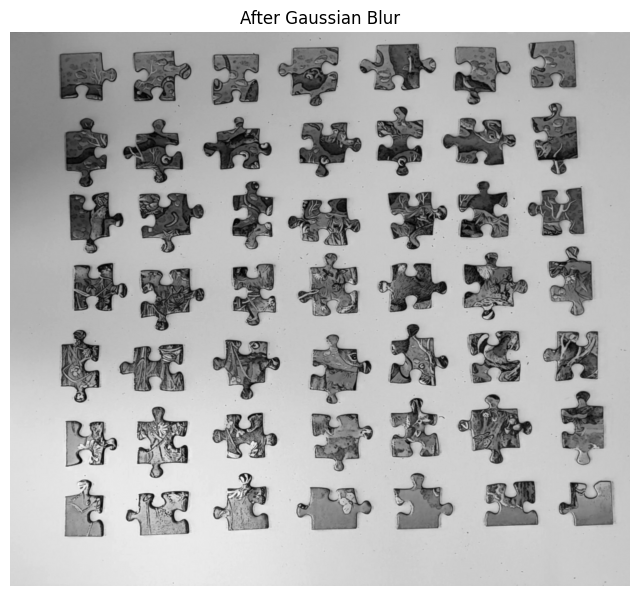

✅ Applied 5x5 Gaussian blur
🎯 STEP 2: Canny edge detection


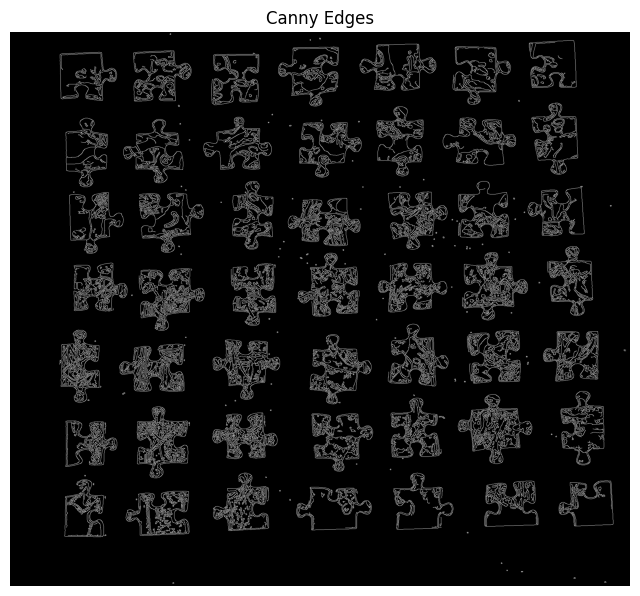

📊 Canny edge statistics:
   Low threshold: 50
   High threshold: 150
   Edge pixels: 207,133 (5.71%)
📈 STEP 3: Dilation - thicken edges


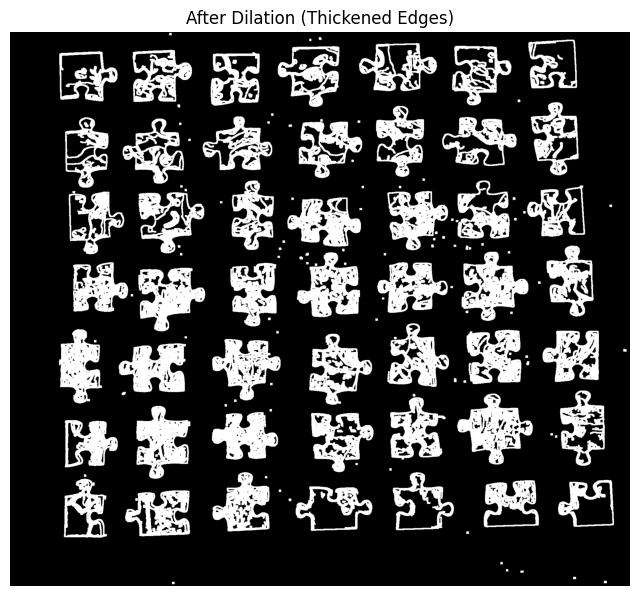

📊 Dilation parameters:
   Kernel size: 3x3
   Iterations: 2
🔗 STEP 4: Morphological closing - fill gaps between edges


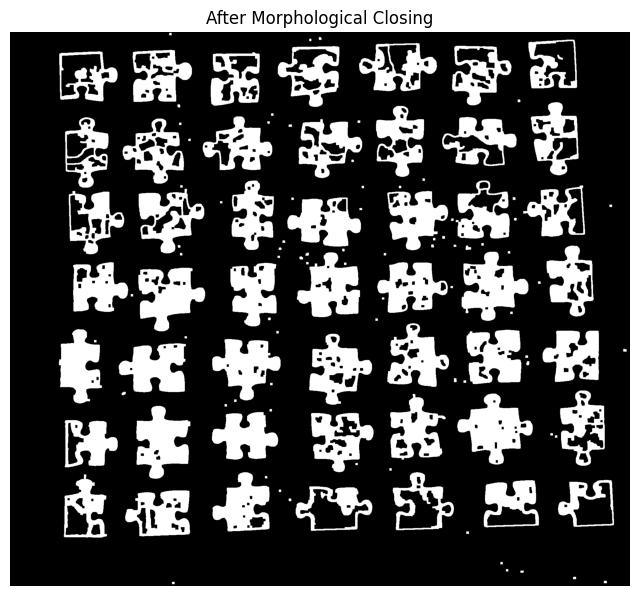

📊 Closing parameters:
   Kernel size: 3x3
   Iterations: 3
🎨 STEP 5: Contour detection and filling
Found 124 contours


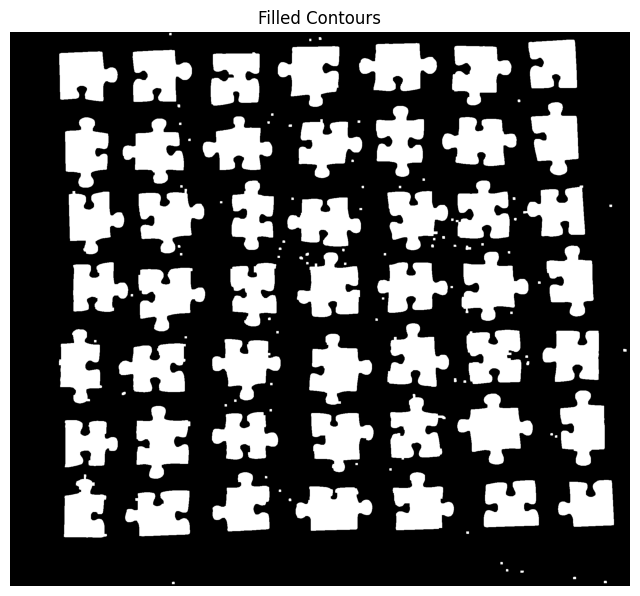

🧹 STEP 6: MODERATE morphological operations for cleanup


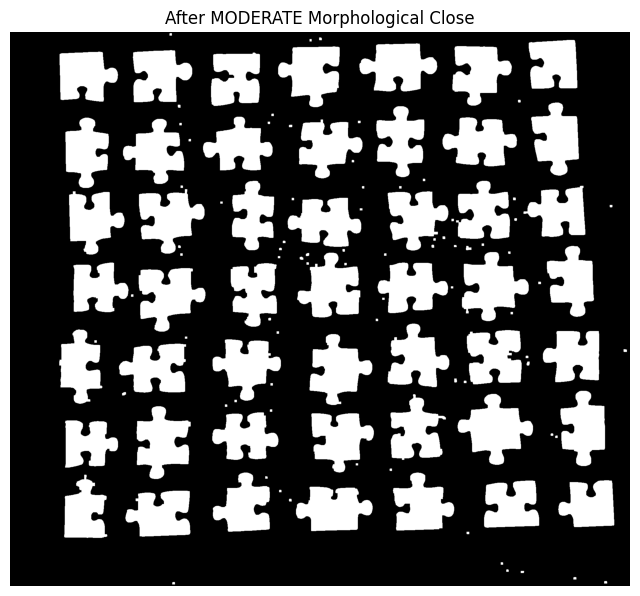

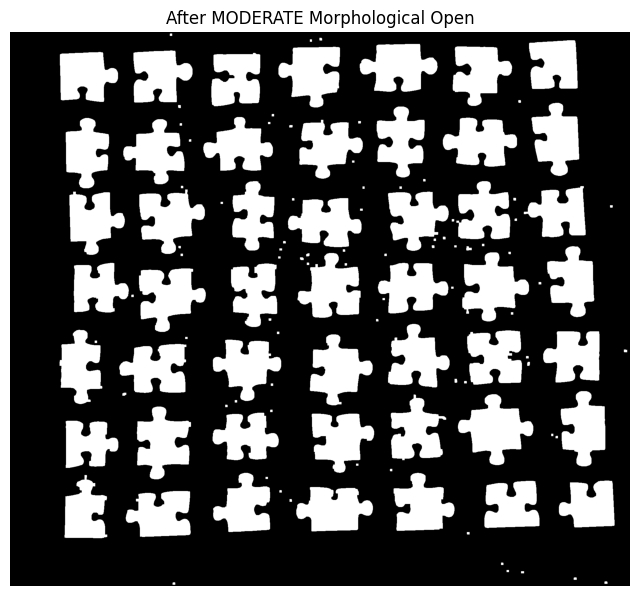

📊 MODERATE cleanup parameters:
   Cleanup kernel size: 6x6
   Iterations: 1 each
📉 STEP 7: Erosion - reduce object size


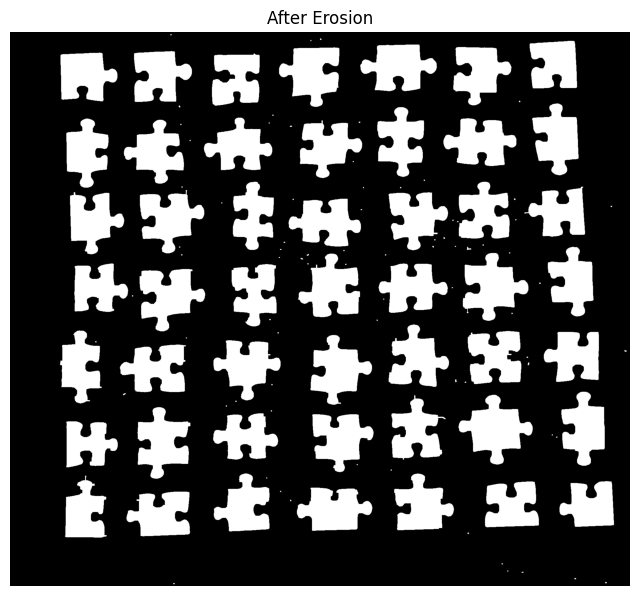

📈 STEP 8: Dilation - restore original size


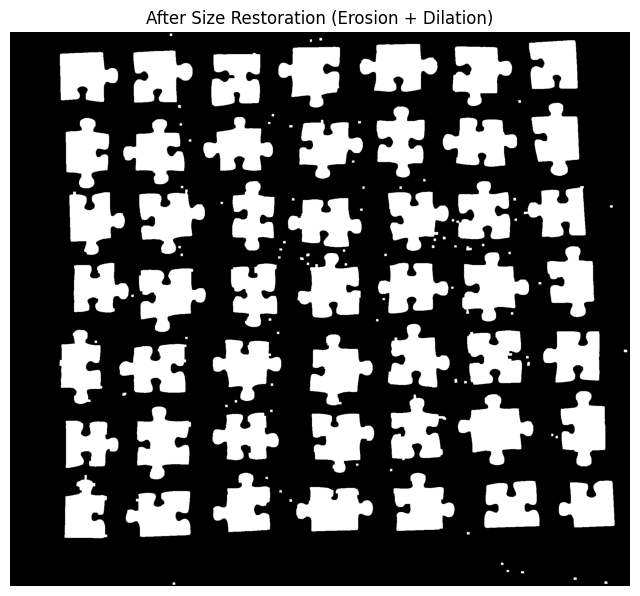

🔧 STEP 8.5: Final shrinking - reduce dilation slightly


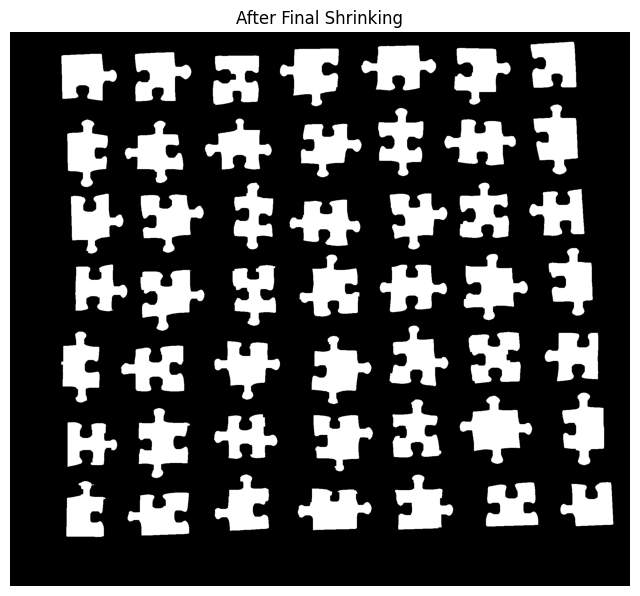

🎯 STEP 9: Final results and analysis
📊 Final Results:
   Objects detected: 49
After filtering: 49 puzzle pieces
Converting to grayscale


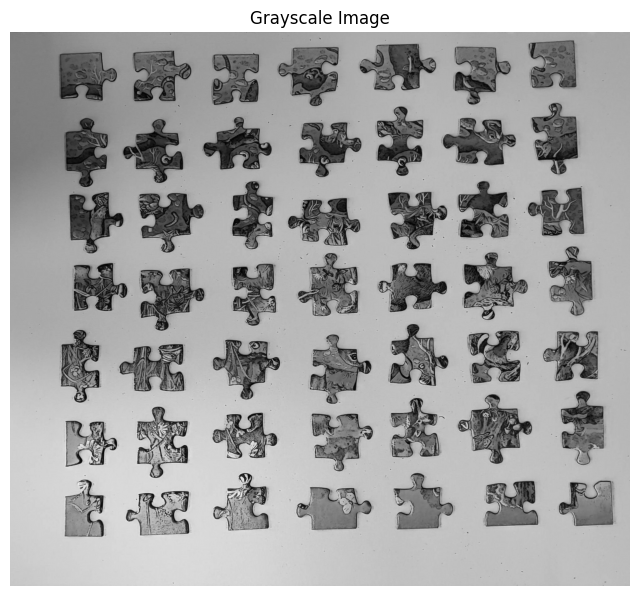

In [262]:
print("Reading image from path:", image_path)

contours, original_image, binary_image = remove_background_canny_edge_detection(
    image_path, debug=True
)

# Convert to grayscale for compatibility with rest of code
print("Converting to grayscale")
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
display_image("Grayscale Image", gray_image)

### Binary thresholding

Free parameters:
- threshold value: `30`
- maxval: `255`

## Morphing

Used to improve the shape and remove impurities

Free parameters:
- kernel ``(12,12)`` // like the size of the morphing

## Contours finding

## Contours drawing

Free parameters:
- thickness: `2`
- rgb: `(0, 255, 0)`

Drawing contours of the original image


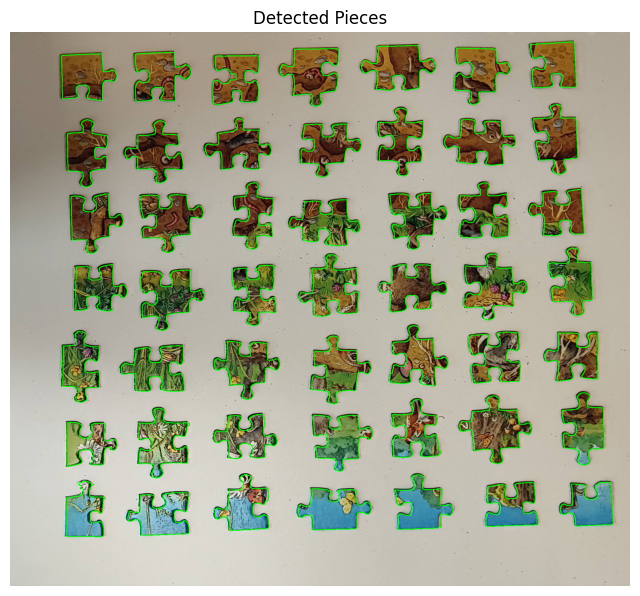

In [263]:
print("Drawing contours of the original image")
contour_image = original_image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
display_image("Detected Pieces", contour_image)

In [264]:
output_folder_pieces = "images/fix/extracted_pieces"
os.makedirs(output_folder_pieces, exist_ok=True)

output_folder_contours = "images/fix/extracted_contours"
os.makedirs(output_folder_contours, exist_ok=True)

output_corner_folder = "images/fix/extracted_corners"
os.makedirs(output_corner_folder, exist_ok=True)

output_plots_folder = "images/fix/corner_plots"
os.makedirs(output_plots_folder, exist_ok=True)

In [265]:
piece_images = []
for i, contour in enumerate(contours):
    mask = np.zeros_like(gray_image)
    cv2.drawContours(mask, [contour], 0, 255, -1)

    piece = np.zeros_like(original_image)
    piece[mask == 255] = original_image[mask == 255]

    x, y, w, h = cv2.boundingRect(contour)
    cropped_piece = piece[y:y + h, x:x + w]
    piece_images.append(cropped_piece)

    piece_path = os.path.join(output_folder_pieces, f"piece_{i + 1}.png")
    cv2.imwrite(piece_path, cropped_piece)

    # Save piece with contour
    contour_piece = cropped_piece.copy()
    mask_cropped = mask[y:y + h, x:x + w]
    cv2.drawContours(contour_piece, [contour - [x, y]], 0, (255, 0, 255), 1,
                     cv2.LINE_8)  # Pink, width 1, no anti-aliasing
    contour_path = os.path.join(output_folder_contours, f"contour_{i + 1}.png")
    cv2.imwrite(contour_path, contour_piece)

## Corners and Edges detection on single piece

In [266]:
selected_image_index = 1

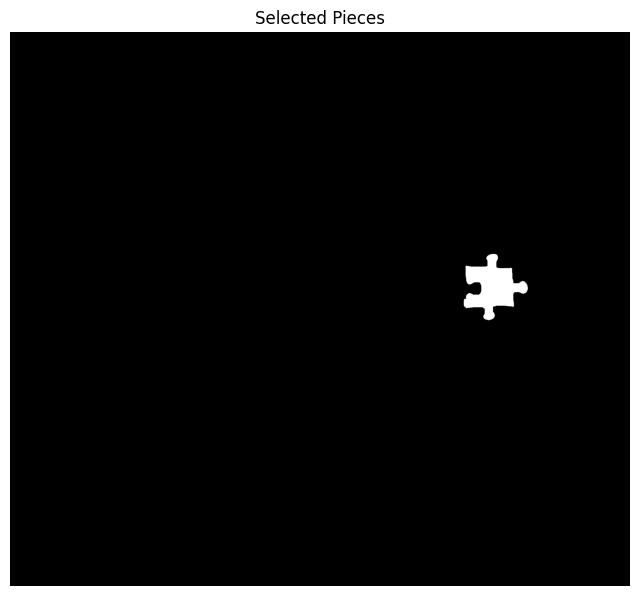

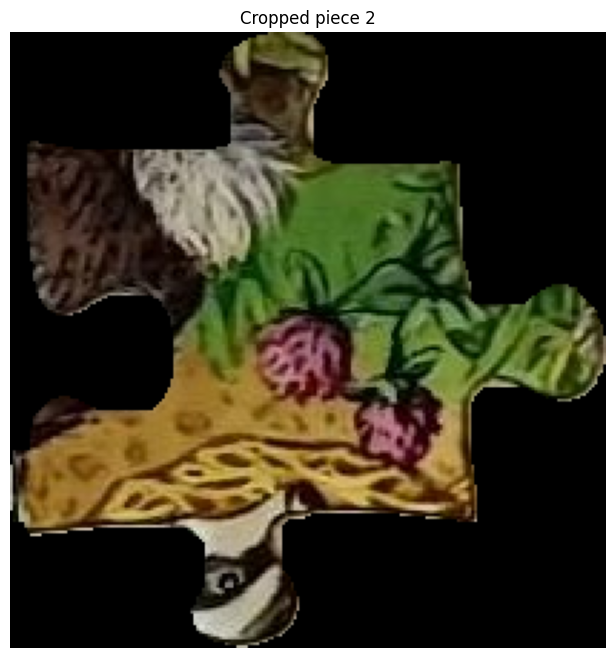

In [267]:
piece_images = []

i = selected_image_index
contour = contours[i]

mask = np.zeros_like(gray_image)
cv2.drawContours(mask, [contour], 0, 255, -1)

display_image("Selected Pieces", mask)

piece = np.zeros_like(original_image)
piece[mask == 255] = original_image[mask == 255]
x, y, w, h = cv2.boundingRect(contour)
cropped_piece = piece[y:y + h, x:x + w]
piece_images.append(cropped_piece)

piece_path = os.path.join(output_folder_pieces, f"piece_{i + 1}.png")
cv2.imwrite(piece_path, cropped_piece)
contour_piece = cropped_piece.copy()

display_image(f"Cropped piece {selected_image_index+1}", contour_piece)


## Find the piece center

Free parameters:
- thickness: `2`
- rgb: `(0, 0, 255)`
- circle pos: $(cx, cy)

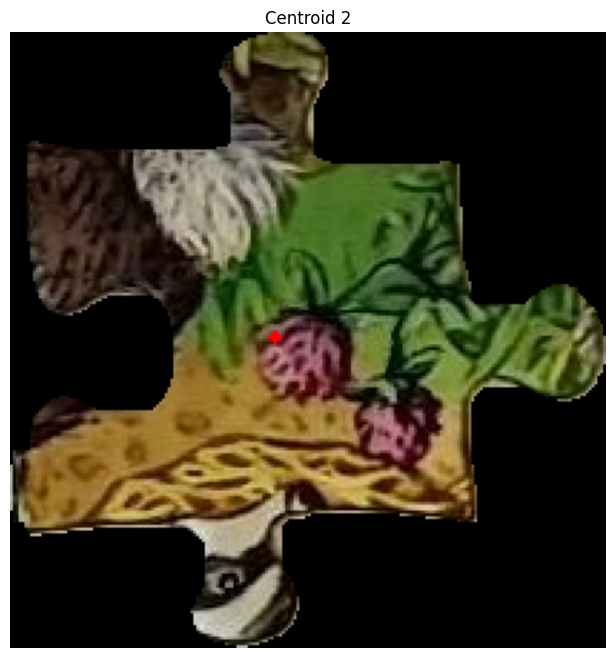

In [268]:
M = cv2.moments(contour)

if M["m00"] == 0:
    print("ERROR")
centroid_x = int(M["m10"] / M["m00"])
centroid_y = int(M["m01"] / M["m00"])
cv2.circle(contour_piece, (centroid_x - x, centroid_y - y), 2, (0, 0, 255), -1)
display_image(f"Centroid {i+1}", contour_piece)

## Rainbow contour ( for testing )

In [269]:
def rainbow_color(t):
    t = t % 256  # wrap around after 255
    phase = t / 256 * 6
    x = int(255 * (1 - abs(phase % 2 - 1)))
    if phase < 1:     return (255, x, 0)       # Red → Yellow
    elif phase < 2:   return (x, 255, 0)       # Yellow → Green
    elif phase < 3:   return (0, 255, x)       # Green → Cyan
    elif phase < 4:   return (0, x, 255)       # Cyan → Blue
    elif phase < 5:   return (x, 0, 255)       # Blue → Magenta
    else:             return (255, 0, x)

1474 723


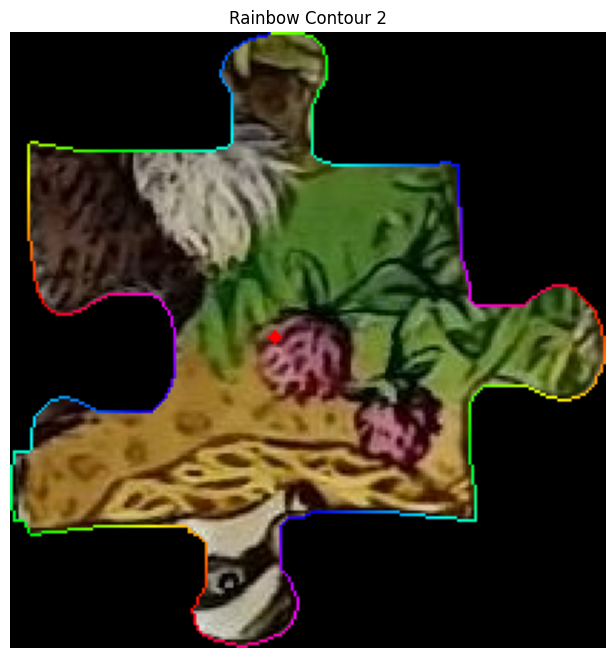

In [270]:
rainbow_piece = contour_piece.copy()

print(x, y)

contour_points = contour - np.array([x, y])
counter = 0
for point in contour:

    px, py = point[0]
    rainbow_piece[py - y, px -  x] = (rainbow_color(counter))
    counter += 1

display_image(f"Rainbow Contour {i+1}", rainbow_piece)


## Transform the contour into polar coordinates

***Note: inverted angles in the plot -> for clockwise plot***

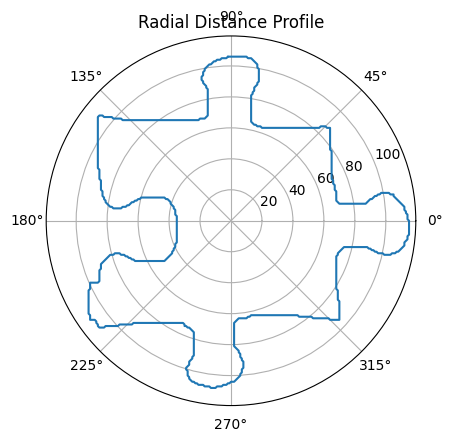

In [271]:
contour_points = contour - np.array([x, y])
distances = []
angles = []
for point in contour:
    px, py = point[0]
    dx = px - centroid_x
    dy = py - centroid_y
    distance = np.sqrt(dx ** 2 + dy ** 2)
    angle = np.arctan2(dy, dx)
    distances.append(distance)
    angles.append(angle)

angles_deg = np.array([(a * 180 / np.pi) % 360 for a in angles])

plt.polar(-np.array(angles), distances)
plt.title("Radial Distance Profile")
plt.show()

# Data reduction

In [272]:
# angles_deg = np.roll(angles_deg, -len(angles_deg) // 2)
# distances = np.roll(distances, -len(distances) // 2)

distances = gaussian_filter1d(distances, sigma=2)

free parameters:
- marker: `.`

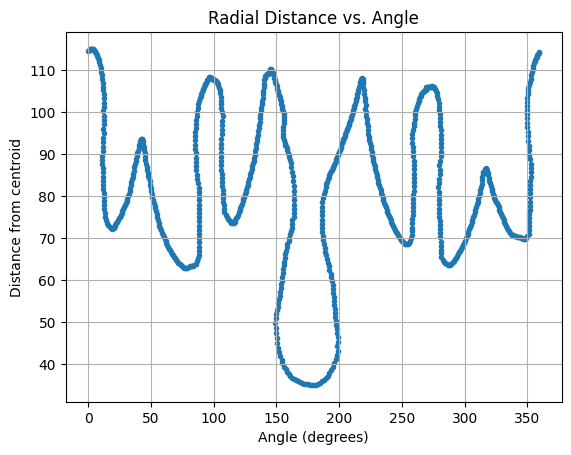

In [273]:
plt.style.use('default')
plt.scatter(angles_deg, distances, marker='.')
plt.xlabel("Angle (degrees)")
plt.ylabel("Distance from centroid")
plt.title("Radial Distance vs. Angle")
plt.grid(True)

output_test = "images/fix/tests"
os.makedirs(output_test, exist_ok=True)

plt.savefig(os.path.join(output_test, f"distance_profile_{i + 1}.png"))

plt.show()


## Peaks detection

Free parameters:
- ``min_distance_between_peaks``
- ``prominence``

In [274]:
delta_s = len(angles_deg) // 4

angles_deg_s = np.roll(angles_deg, -delta_s)
distances_s = np.roll(distances, -delta_s)

# find the maxima
min_distance_between_peaks = len(distances) // 20
# print(min_distance_between_peaks, len(distances)) # for data analysis
all_peak_indices, all_peak_properties = find_peaks(distances,                                 distance=min_distance_between_peaks,prominence=2)

all_peak_indices_s, all_peak_properties_s = find_peaks(distances_s,                                 distance=min_distance_between_peaks,prominence=2)

all_peak_indices_u = [(x+delta_s)%len(angles_deg) for x in all_peak_indices_s]
all_peak_indices_f = [y for y in all_peak_indices_u if y not in all_peak_indices]

for val in all_peak_indices_f:
    pos = np.searchsorted(all_peak_indices, val)
    all_peak_indices = np.insert(all_peak_indices, pos, val)

# print(all_peak_properties)
peak_angles = [angles_deg[peak_idx] for peak_idx in all_peak_indices]
peak_distances = [distances[peak_idx] for peak_idx in all_peak_indices]

# find the minima
inverted_distances = [-d for d in distances]
all_min_indices, all_min_properties = find_peaks(inverted_distances,
                                 distance=min_distance_between_peaks,prominence=0.1)

min_angles = [angles_deg[min_idx] for min_idx in all_min_indices]
min_distances = [distances[min_idx] for min_idx in all_min_indices]

min_distances_avg = np.mean(min_distances)

In [275]:
print(all_peak_indices)
print(all_peak_indices_s)
print(all_peak_indices_u)
print(all_peak_indices_f)

[116 332 448 568 664 771 868]
[113 229 349 445 552 649 775]
[np.int64(332), np.int64(448), np.int64(568), np.int64(664), np.int64(771), np.int64(868), np.int64(116)]
[np.int64(868)]


### Peaks table display

note: before etra peak removal


In [276]:
df = pd.DataFrame({
    'Index': all_peak_indices,         # Peak indices
    'Angle (degrees)': peak_angles,    # Peak angles
    'Distance': peak_distances         # Peak distances
})

df

Index  Angle (degrees)    Distance
0    116       217.921078  108.157764
1    332       145.304846  110.257912
2    448        96.340192  108.354540
3    568        42.436230   93.754313
4    664         2.986637  115.134335
5    771       316.847610   86.707287
6    868       274.316028  106.214269

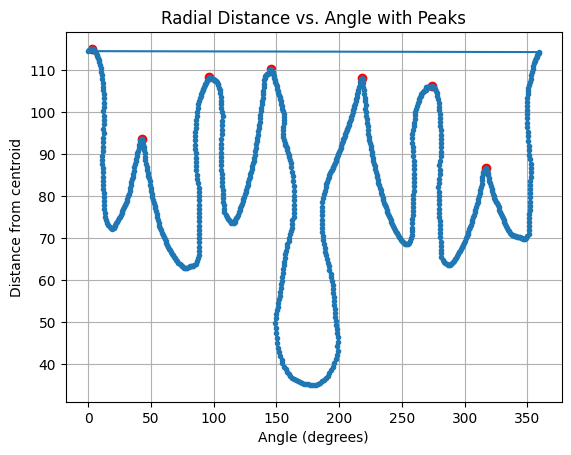

In [277]:
plt.style.use('default')
plt.plot(angles_deg, distances, marker='.')
plt.scatter(peak_angles, peak_distances, color='red', marker='o', label='Peaks')
plt.xlabel("Angle (degrees)")
plt.ylabel("Distance from centroid")
plt.title("Radial Distance vs. Angle with Peaks")
plt.grid(True)
plt.show()

## Minima table display

In [278]:
df2 = pd.DataFrame({
    'Index': all_min_indices,         # Peak indices
    'Angle (degrees)': min_angles,    # Peak angles
    'Distance': min_distances         # Peak distances
})

df2

Index  Angle (degrees)   Distance
0     49       253.940013  68.650063
1    226       178.363423  35.082598
2    395       115.159302  73.639978
3    512        77.074001  62.874812
4    609        18.687352  72.343038
5    726       347.560438  69.807714
6    816       287.300527  63.655515

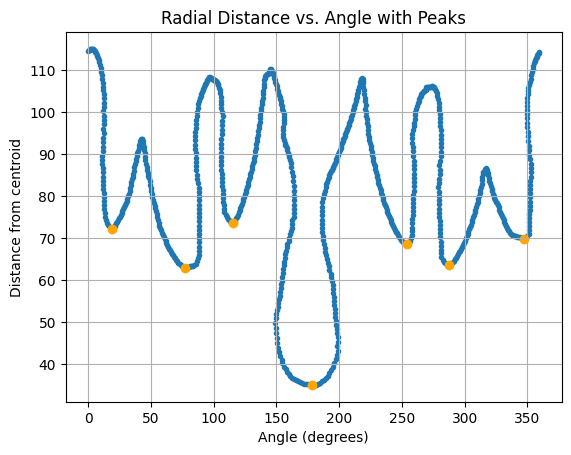

In [279]:
plt.style.use('default')
plt.scatter(angles_deg, distances, marker='.')
plt.scatter(min_angles, min_distances, color='orange', marker='o', label='Peaks')
plt.xlabel("Angle (degrees)")
plt.ylabel("Distance from centroid")
plt.title("Radial Distance vs. Angle with Peaks")
plt.grid(True)
plt.show()

## Remove the extra peaks

Free parameters:
- ``max_angle_diff``

In [280]:
max_angle_diff = 25
delCounter = 0

remaining_peak_indices = all_peak_indices.tolist() if isinstance(all_peak_indices, np.ndarray) else all_peak_indices.copy()
remaining_peak_angles = peak_angles.tolist() if isinstance(peak_angles, np.ndarray) else peak_angles.copy()
remaining_peak_distances = peak_distances.tolist() if isinstance(peak_distances, np.ndarray) else peak_distances.copy()

while True:
    removals_made = False

    for k in range(len(remaining_peak_angles)):
        if len(remaining_peak_angles) <= 1:
            break

        if remaining_peak_distances[k] <= min_distances_avg:
            print("removing a bottom peak")
            remaining_peak_indices.pop(k)
            remaining_peak_angles.pop(k)
            remaining_peak_distances.pop(k)
            break


        next_k = (k + 1) % len(remaining_peak_angles)  # Wrap-around logic

        if abs(remaining_peak_angles[next_k] - remaining_peak_angles[k]) < max_angle_diff:
            delCounter += 1
            removals_made = True

            if remaining_peak_distances[k] < remaining_peak_distances[next_k]:
                remaining_peak_indices.pop(k)
                remaining_peak_angles.pop(k)
                remaining_peak_distances.pop(k)
            else:
                remaining_peak_indices.pop(next_k)
                remaining_peak_angles.pop(next_k)
                remaining_peak_distances.pop(next_k)

            break


    if not removals_made or len(remaining_peak_angles) <= 1:
        break

all_peak_indices = np.array(remaining_peak_indices) if isinstance(all_peak_indices, np.ndarray) else remaining_peak_indices
peak_angles = np.array(remaining_peak_angles) if isinstance(peak_angles, np.ndarray) else remaining_peak_angles
peak_distances = np.array(remaining_peak_distances) if isinstance(peak_distances, np.ndarray) else remaining_peak_distances

# Print out the result
print(f"We deleted {delCounter} extra peak angles")

We deleted 0 extra peak angles


## Drawing the maxima

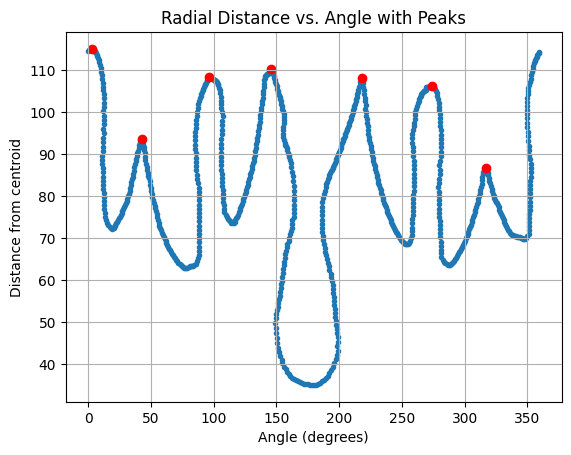

In [281]:
plt.style.use('default')
plt.scatter(angles_deg, distances, marker='.')
plt.scatter(peak_angles, peak_distances, color='red', marker='o', label='Peaks')
plt.xlabel("Angle (degrees)")
plt.ylabel("Distance from centroid")
plt.title("Radial Distance vs. Angle with Peaks")
plt.grid(True)
plt.show()

## Drawing the minima

In [282]:
print(all_min_indices)
print(min_distances_avg)

[ 49 226 395 512 609 726 816]
63.72195959012417


In [283]:
# new_min_indice = []
#
# for min_indice in all_min_indices:
#     if distances[min_indice] < min_distances_avg:
#         new_min_indice.append(min_indice)
#
# all_min_indices = np.array(new_min_indice)


new_min_indice = all_min_indices.copy()


In [284]:
min_angles = [angles_deg[min_idx] for min_idx in new_min_indice]
min_distances = [distances[min_idx] for min_idx in new_min_indice]

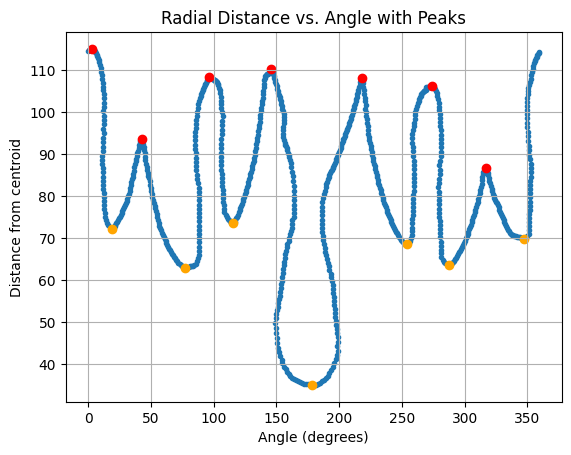

In [285]:
plt.style.use('default')
plt.scatter(angles_deg, distances, marker='.')
plt.scatter(peak_angles, peak_distances, color='red', marker='o', label='Peaks')
plt.scatter(min_angles, min_distances, color='orange', marker='o', label='Minima')
plt.xlabel("Angle (degrees)")
plt.ylabel("Distance from centroid")
plt.title("Radial Distance vs. Angle with Peaks")
plt.grid(True)
plt.show()

# [52 146 255 385 464 565 655]

## Find the 4 corners

They are defined as the top4 most pointy minima

[116 332 448 568 664 771 868]
[0, 1, 3, 5]
[np.int64(116), np.int64(332), np.int64(568), np.int64(771)]
[116, 332, 568, 771]
[np.int64(448), np.int64(664), np.int64(868)]
[np.float64(217.92107839538775), np.float64(145.30484646876604), np.float64(42.436229788534995), np.float64(316.8476102659946)]
[np.float64(108.15776428054647), np.float64(110.25791154211565), np.float64(93.7543132025618), np.float64(86.7072874552337)]


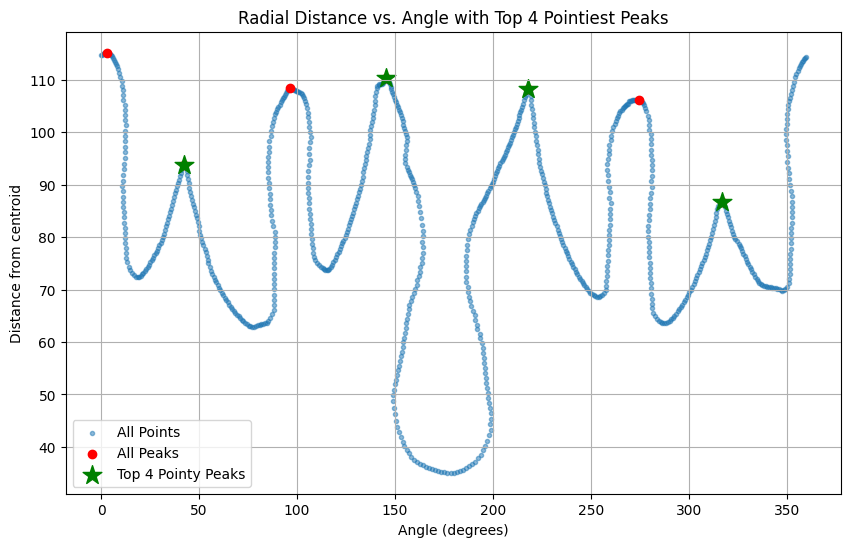

Peak 1: Angle = 217.92°, Distance = 108.16, Pointiness = 15.57
Peak 2: Angle = 145.30°, Distance = 110.26, Pointiness = 4.78
Peak 3: Angle = 96.34°, Distance = 108.35, Pointiness = 2.16
Peak 4: Angle = 42.44°, Distance = 93.75, Pointiness = 15.58
Peak 5: Angle = 2.99°, Distance = 115.13, Pointiness = 2.51
Peak 6: Angle = 316.85°, Distance = 86.71, Pointiness = 13.28
Peak 7: Angle = 274.32°, Distance = 106.21, Pointiness = 4.67

Top 4 pointiest peaks:
Peak 1: Angle = 217.92°, Distance = 108.16, Pointiness = 15.57
Peak 2: Angle = 145.30°, Distance = 110.26, Pointiness = 4.78
Peak 4: Angle = 42.44°, Distance = 93.75, Pointiness = 15.58
Peak 6: Angle = 316.85°, Distance = 86.71, Pointiness = 13.28


In [286]:
def robust_pointiness(angles_deg, distances, peak_indices, window_small=5, window_large=15):
    pointiness_scores = []

    for peak_idx in peak_indices:
        small_left = max(0, peak_idx - window_small)
        small_right = min(len(distances) - 1, peak_idx + window_small)
        small_window = distances[small_left:small_right+1]

        large_left = max(0, peak_idx - window_large)
        large_right = min(len(distances) - 1, peak_idx + window_large)
        large_window = distances[large_left:large_right+1]

        peak_height = distances[peak_idx]
        small_avg = np.mean(small_window)
        large_avg = np.mean(large_window)

        pointiness = (peak_height - large_avg) * (small_avg - large_avg)
        pointiness_scores.append(pointiness)

    return pointiness_scores

pointiness_scores = robust_pointiness(angles_deg, distances, all_peak_indices)

top_4_indices = sorted(range(len(pointiness_scores)),
                      key=lambda i: pointiness_scores[i],
                      reverse=True)[:4]

top_4_indices = sorted(top_4_indices)
top_4_peak_indices = [all_peak_indices[i] for i in top_4_indices]

temp = [int(w) for w in top_4_peak_indices]
remaining_indices = [z for z in all_peak_indices if z not in temp]

top_4_angles = [angles_deg[i] for i in top_4_peak_indices]
top_4_distances = [distances[i] for i in top_4_peak_indices]

print(all_peak_indices)
print(top_4_indices)
print(top_4_peak_indices)
print(temp)
print(remaining_indices)
print(top_4_angles)
print(top_4_distances)

plt.figure(figsize=(10, 6))
plt.scatter(angles_deg, distances, marker='.', alpha=0.5, label='All Points')
plt.scatter(peak_angles, peak_distances, color='red', marker='o', label='All Peaks')
plt.scatter(top_4_angles, top_4_distances, color='green', marker='*', s=200, label='Top 4 Pointy Peaks')
plt.xlabel("Angle (degrees)")
plt.ylabel("Distance from centroid")
plt.title("Radial Distance vs. Angle with Top 4 Pointiest Peaks")
plt.legend()
plt.grid(True)
plt.show()

# Print pointiness scores for all peaks
for i, (angle, distance, score) in enumerate(zip(peak_angles, peak_distances, pointiness_scores)):
    print(f"Peak {i+1}: Angle = {angle:.2f}°, Distance = {distance:.2f}, Pointiness = {score:.2f}")
print("\nTop 4 pointiest peaks:")
for i, idx in enumerate(top_4_indices):
    print(f"Peak {idx+1}: Angle = {peak_angles[idx]:.2f}°, Distance = {peak_distances[idx]:.2f}, Pointiness = {pointiness_scores[idx]:.2f}")

## Draw the 4 corners

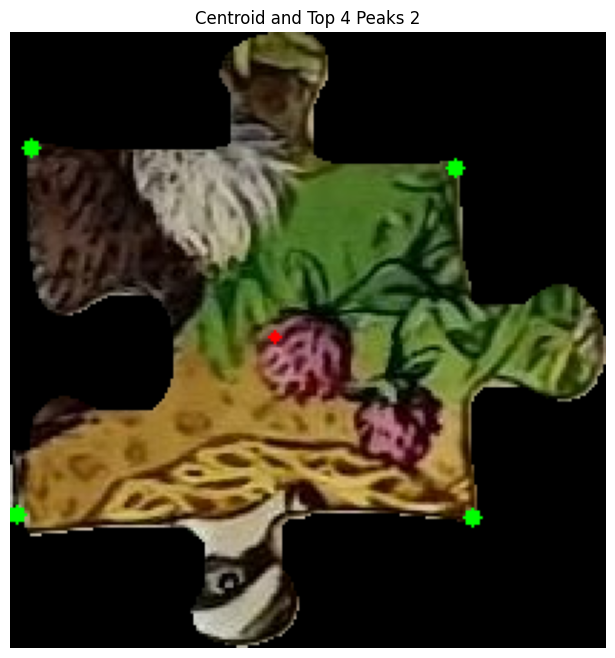

Peak coordinates (x, y):
Peak 1: (7, 40)
Peak 2: (2, 168)
Peak 3: (161, 169)
Peak 4: (155, 47)


In [287]:
contour_piece_with_peaks = contour_piece.copy()

cv2.circle(contour_piece_with_peaks, (centroid_x - x, centroid_y - y), 2, (0, 0, 255), -1)

peak_coords = []
for angle, distance in zip(top_4_angles, top_4_distances):
    angle_rad = np.radians(angle)

    dx = int(distance * np.cos(angle_rad))
    dy = int(distance * np.sin(angle_rad))

    peak_x = (centroid_x - x) + dx
    peak_y = (centroid_y - y) + dy

    cv2.circle(contour_piece_with_peaks, (peak_x, peak_y), 3, (0, 255, 0), -1)
    peak_coords.append((peak_x, peak_y))

display_image(f"Centroid and Top 4 Peaks {selected_image_index+1}", contour_piece_with_peaks)

print("Peak coordinates (x, y):")
for idx, (px, py) in enumerate(peak_coords):
    print(f"Peak {idx+1}: ({px}, {py})")

In [288]:
class puzzlePiece:
    def __init__(self, piece_id, contour, peaks_ids, center, angles, distances):
        self.piece_id = piece_id
        self.contour = contour
        self.corners = peaks_ids
        self.center = center
        self.contour_polar = (angles, distances)
        self.edges = []

    def __repr__(self):
        ret = ""
        ret += f"{self.piece_id}\n"
        ret += f"Contour: {len(self.contour)}\n"
        ret += f"Corners: {self.corners}\n"

        return ret

puzzle_pieces_holder = {}

this_piece = puzzlePiece(
    1,
    contour,
    top_4_peak_indices,
    (centroid_x - x, centroid_y - y),
    angles_deg,
    distances
)

print(this_piece)


1
Contour: 878
Corners: [np.int64(116), np.int64(332), np.int64(568), np.int64(771)]



## Edge type detection

In [289]:
def exists_peak_between(a,b,peak_indices):
    if b < a:
        for p in peak_indices:
            if p > a or p < b:
                print(f"Found maxima {p}")
                return True

    else:
        for p in peak_indices:
            if p > a and p < b:
                print(f"Found maxima {p}")
                return True

        print("no peak between")
        return False

In [290]:
def exists_minima_between(a,b,min_indices):
    if b < a:
        for p in min_indices:
            if p > a or p < b:
                # hack to set distance smaller than custom threshold
                if distances[p] < ((max(distances[a], distances[b])*0.8 ) /1.41):
                    print(f"Found minima {p} with distance {distances[p]}")
                    return True
                else:
                    return False

    else:
        for p in min_indices:
            if p > a and p < b:
                if distances[p] < ((max(distances[a], distances[b])*0.8 ) /1.41):
                    print(f"Found minima {p} with distance {distances[p]}")
                    return True
                else:
                    return False

        print("no min between")
        return False

In [291]:
edge_types = {0: "FLAT", 1: "IN", 2: "OUT"}
print(all_min_indices)

def get_edge_type(a, b):
    print("-----")
    print(a, b)
    print(angles_deg[a], angles_deg[b])

    print(remaining_indices)
    print([angles_deg[r] for r in remaining_indices])
    if exists_peak_between(a, b, remaining_indices):
        return 2
    else:
        if exists_minima_between(a, b, all_min_indices):
            return 1
        else:
            return 0


[ 49 226 395 512 609 726 816]


In [292]:
class Edge:
    def __init__(self, edge_type, left_corner, right_corner):
        self.edge_type = edge_type
        self.left_corner = left_corner
        self.right_corner = right_corner


In [293]:
edges = []

for c, corner in enumerate(top_4_peak_indices):
    corner1 = top_4_peak_indices[c]
    corner2 = top_4_peak_indices[(c+1) % len(top_4_peak_indices)]

    edges.append((c, corner1, corner2, get_edge_type(corner1, corner2)))

this_piece.edges = edges

print(edges)

-----
116 332
217.92107839538775 145.30484646876604
[np.int64(448), np.int64(664), np.int64(868)]
[np.float64(96.3401917459099), np.float64(2.9866369904751666), np.float64(274.31602751986566)]
no peak between
Found minima 226 with distance 35.08259771103888
-----
332 568
145.30484646876604 42.436229788534995
[np.int64(448), np.int64(664), np.int64(868)]
[np.float64(96.3401917459099), np.float64(2.9866369904751666), np.float64(274.31602751986566)]
Found maxima 448
-----
568 771
42.436229788534995 316.8476102659946
[np.int64(448), np.int64(664), np.int64(868)]
[np.float64(96.3401917459099), np.float64(2.9866369904751666), np.float64(274.31602751986566)]
Found maxima 664
-----
771 116
316.8476102659946 217.92107839538775
[np.int64(448), np.int64(664), np.int64(868)]
[np.float64(96.3401917459099), np.float64(2.9866369904751666), np.float64(274.31602751986566)]
Found maxima 868
[(0, np.int64(116), np.int64(332), 1), (1, np.int64(332), np.int64(568), 2), (2, np.int64(568), np.int64(771), 2),

In [294]:
for edge_id, start_idx, end_idx, edge_type in edges:
    print(angles_deg[start_idx], angles_deg[end_idx])

217.92107839538775 145.30484646876604
145.30484646876604 42.436229788534995
42.436229788534995 316.8476102659946
316.8476102659946 217.92107839538775


## Draw edges in a different color ( testing )

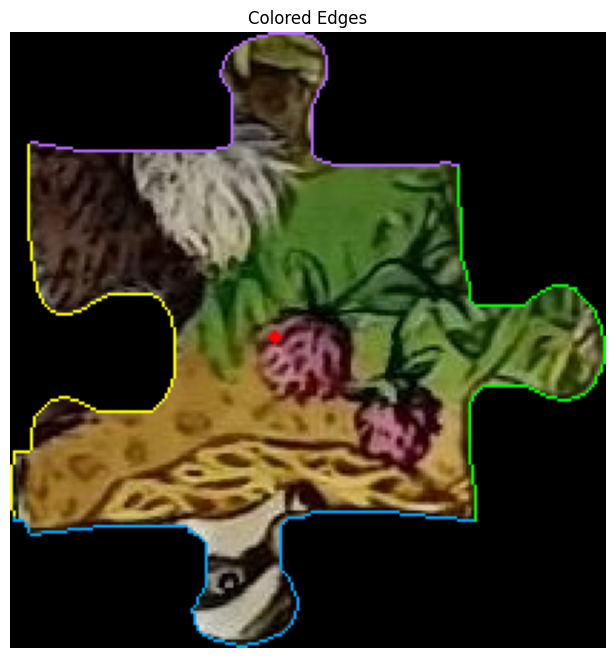

In [295]:
color_edge_piece = contour_piece.copy()

contour_points = contour.reshape(-1, 2)
contour_points_shifted = contour_points - np.array([x, y])  # apply shift

edge_colors = [
    (0, 255, 255),   # Cyan
    (255, 165, 0),   # Orange
    (0, 255, 0),     # Green
    (255, 105, 180)  # Pink
]

for edge_id, start_idx, end_idx, edge_type in edges:
    color = edge_colors[edge_id]
    if start_idx < end_idx:
        indices = range(start_idx, end_idx)
    else:
        indices = list(range(start_idx, len(contour_points))) + list(range(0, end_idx))

    for idx in indices:
        px, py = contour_points_shifted[idx]
        color_edge_piece[py, px] = color

display_image(f"Colored Edges", color_edge_piece)


## Draw edges types with Corners

In [296]:
# angles_deg = np.roll(angles_deg, +len(angles_deg) // 4)
# distances = np.roll(distances, +len(distances) // 4)

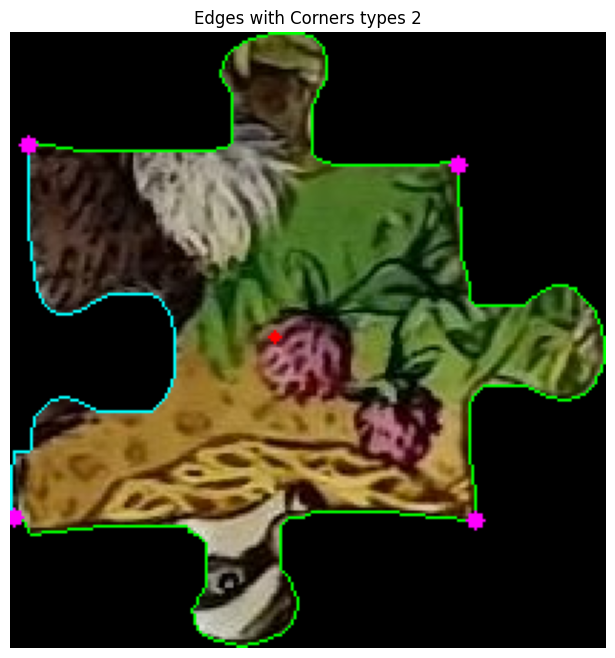

In [297]:
color_edge_corner_piece = contour_piece.copy()

contour_points = contour.reshape(-1, 2)
contour_points_shifted = contour_points - np.array([x, y])  # apply shift

edge_colors = {
    0: (0, 0, 255),   # Blue for edge_type 0
    1: (255, 255, 0), # Yellow for edge_type 1
    2: (0, 255, 0)    # Green for edge_type 2
}

corner_color = (255, 0, 255)  # Purple color for corners
for edge_id, start_idx, end_idx, edge_type in edges:
    start_px, start_py = contour_points[start_idx] - np.array([x, y])
    end_px, end_py = contour_points[end_idx] - np.array([x, y])

    color = edge_colors[edge_type]
    if start_idx < end_idx:
        indices = range(start_idx, end_idx)
    else:
        indices = list(range(start_idx, len(contour_points))) + list(range(0, end_idx))

    for idx in indices:
        px, py = contour_points_shifted[idx]
        color_edge_corner_piece[py, px] = color

    cv2.circle(color_edge_corner_piece, (start_px, start_py), 3, corner_color, -1)  # Start corner
    cv2.circle(color_edge_corner_piece, (end_px, end_py), 3, corner_color, -1)    # End corner

display_image(f"Edges with Corners types {selected_image_index+1}", color_edge_corner_piece)
